# 数据挖掘互评作业二: 频繁模式与关联规则挖掘
#### 07112005 1120202685 马梓奥

## Microsoft资讯推荐

### 0. 数据预处理

In [2]:
import os
import urllib
import zipfile
import pandas as pd

# Temporary folder for data we need during execution of this notebook (we'll clean up
# at the end, we promise)
# temp_dir = os.path.join(tempfile.gettempdir(), 'mind')
temp_dir = '/data/mza/datasets/microsoft-news'
os.makedirs(temp_dir, exist_ok=True)

# The dataset is split into training and validation set, each with a large and small version.
# The format of the four files are the same.
# For demonstration purpose, we will use small version validation set only.
base_url = 'https://mind201910small.blob.core.windows.net/release'
training_small_url = f'{base_url}/MINDsmall_train.zip'
validation_small_url = f'{base_url}/MINDsmall_dev.zip'
training_large_url = f'{base_url}/MINDlarge_train.zip'
validation_large_url = f'{base_url}/MINDlarge_dev.zip'

In [3]:
def download_url(url,
                 destination_filename=None,
                 progress_updater=None,
                 force_download=False,
                 verbose=True):
    """
    Download a URL to a temporary file
    """
    if not verbose:
        progress_updater = None
    # This is not intended to guarantee uniqueness, we just know it happens to guarantee
    # uniqueness for this application.
    if destination_filename is None:
        url_as_filename = url.replace('://', '_').replace('/', '_')
        destination_filename = \
            os.path.join(temp_dir,url_as_filename)
    if (not force_download) and (os.path.isfile(destination_filename)):
        if verbose:
            print('Bypassing download of already-downloaded file {}'.format(
                os.path.basename(url)))
        return destination_filename
    if verbose:
        print('Downloading file {} to {}'.format(os.path.basename(url),
                                                 destination_filename),
              end='')
    urllib.request.urlretrieve(url, destination_filename, progress_updater)
    assert (os.path.isfile(destination_filename))
    nBytes = os.path.getsize(destination_filename)
    if verbose:
        print('...done, {} bytes.'.format(nBytes))
    return destination_filename

In [37]:
# For demonstration purpose, we will use small version validation set only.
# This file is about 30MB.
zip_path = download_url(validation_small_url, verbose=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(temp_dir)

os.listdir(temp_dir)

Bypassing download of already-downloaded file MINDsmall_dev.zip


['relation_embedding.vec',
 'entity_embedding.vec',
 'news.tsv',
 'https_mind201910small.blob.core.windows.net_release_MINDsmall_dev.zip',
 'behaviors.tsv']

### 1. 数据加载

In [4]:
# The behaviors.tsv file contains the impression logs and users' news click histories. 
# It has 5 columns divided by the tab symbol:
# - Impression ID. The ID of an impression.
# - User ID. The anonymous ID of a user.
# - Time. The impression time with format "MM/DD/YYYY HH:MM:SS AM/PM".
# - History. The news click history (ID list of clicked news) of this user before this impression.
# - Impressions. List of news displayed in this impression and user's click behaviors on them (1 for click and 0 for non-click).
behaviors_path = os.path.join(temp_dir, 'behaviors.tsv')
behaviors = pd.read_table(
    behaviors_path,
    header=None,
    names=['impression_id', 'user_id', 'time', 'history', 'impressions'])

用户阅读历史记录分割

In [7]:
behaviors_history = []
for item in behaviors['history']:
    if pd.notna(item):
        single_user_behaviors = item.split(' ')
    else:
        continue
    behaviors_history.append(single_user_behaviors)

behaviors_history[0]

['N55189',
 'N46039',
 'N51741',
 'N53234',
 'N11276',
 'N264',
 'N40716',
 'N28088',
 'N43955',
 'N6616',
 'N47686',
 'N63573',
 'N38895',
 'N30924',
 'N35671']

新闻ID与类别、子类别对应字典构建

In [10]:
# The news.tsv file contains the detailed information of news articles involved in the behaviors.tsv file.
# It has 7 columns, which are divided by the tab symbol:
# - News ID
# - Category
# - Subcategory
# - Title
# - Abstract
# - URL
# - Title Entities (entities contained in the title of this news)
# - Abstract Entities (entities contained in the abstract of this news)
news_path = os.path.join(temp_dir, 'news.tsv')
news_table = pd.read_table(news_path,
              header=None,
              names=[
                  'id', 'category', 'subcategory', 'title', 'abstract', 'url',
                  'title_entities', 'abstract_entities'
              ])
news_ref = {news_table['id'][i]: {'category': news_table['category'][i], 'subcategory': news_table['subcategory'][i]} for i in news_table.index}
list(news_ref.items())[:10]

[('N55528', {'category': 'lifestyle', 'subcategory': 'lifestyleroyals'}),
 ('N18955', {'category': 'health', 'subcategory': 'medical'}),
 ('N61837', {'category': 'news', 'subcategory': 'newsworld'}),
 ('N53526', {'category': 'health', 'subcategory': 'voices'}),
 ('N38324', {'category': 'health', 'subcategory': 'medical'}),
 ('N2073', {'category': 'sports', 'subcategory': 'football_nfl'}),
 ('N11429', {'category': 'news', 'subcategory': 'newsscienceandtechnology'}),
 ('N49186', {'category': 'weather', 'subcategory': 'weathertopstories'}),
 ('N2131', {'category': 'health', 'subcategory': 'weightloss'}),
 ('N59295', {'category': 'news', 'subcategory': 'newsworld'})]

类别、子类别统计

In [29]:
categories = []
subcategories = []
for i in news_table.index:
    if news_table['category'][i] not in categories:
        categories.append(news_table['category'][i])
    if news_table['subcategory'][i] not in subcategories:
        subcategories.append(news_table['subcategory'][i])
        
print(f"categories ({len(categories)}): {categories}")
print(f"subcategories ({len(subcategories)}): {subcategories}")

categories (17): ['lifestyle', 'health', 'news', 'sports', 'weather', 'entertainment', 'foodanddrink', 'autos', 'travel', 'video', 'tv', 'finance', 'movies', 'music', 'kids', 'middleeast', 'games']
subcategories (257): ['lifestyleroyals', 'medical', 'newsworld', 'voices', 'football_nfl', 'newsscienceandtechnology', 'weathertopstories', 'weightloss', 'gaming', 'recipes', 'nutrition', 'autosenthusiasts', 'wellness', 'health-news', 'celebrity', 'travelarticle', 'autossuvs', 'newspolitics', 'more_sports', 'traveltripideas', 'animals', 'autosnews', 'newsbusiness', 'golf', 'newstrends', 'lifestylepetsanimals', 'football_ncaa', 'tv-gallery', 'basketball_nba', 'news', 'shop-all', 'newsphotos', 'lifestylemindandsoul', 'basketball_ncaa', 'finance-real-estate', 'quickandeasy', 'tv-celebrity', 'lifestyleparenting', 'travelnews', 'movies-gallery', 'lifestylebuzz', 'tipsandtricks', 'autosbuying', 'shop-apparel', 'autostrucks', 'lifestyledidyouknow', 'restaurantsandnews', 'finance-saving-investing', 

### 2. 频繁模式挖掘（项集）

In [12]:
from efficient_apriori import apriori

itemsets, rules = apriori(behaviors_history, min_support=0.02, min_confidence=0.02)

print(f"itemsets ({len(itemsets[2])}): {itemsets[2]}")
print(f"rules ({len(rules)}): {rules}")

itemsets (24): {('N16715', 'N31801'): 1546, ('N29177', 'N306'): 1586, ('N306', 'N31801'): 1741, ('N306', 'N42620'): 2288, ('N306', 'N43142'): 1897, ('N306', 'N45794'): 1830, ('N306', 'N4607'): 1492, ('N306', 'N46392'): 1653, ('N306', 'N51706'): 1426, ('N306', 'N55189'): 1535, ('N306', 'N871'): 1969, ('N31801', 'N42620'): 1492, ('N31801', 'N45794'): 1459, ('N4020', 'N871'): 1421, ('N42620', 'N43142'): 1675, ('N42620', 'N45794'): 1691, ('N42620', 'N4607'): 1611, ('N42620', 'N52551'): 1653, ('N42620', 'N55189'): 1709, ('N42620', 'N871'): 1573, ('N43142', 'N45794'): 1438, ('N43142', 'N51706'): 1497, ('N45794', 'N46392'): 1662, ('N45794', 'N59704'): 1571}
rules (48): [{N31801} -> {N16715}, {N16715} -> {N31801}, {N306} -> {N29177}, {N29177} -> {N306}, {N31801} -> {N306}, {N306} -> {N31801}, {N42620} -> {N306}, {N306} -> {N42620}, {N43142} -> {N306}, {N306} -> {N43142}, {N45794} -> {N306}, {N306} -> {N45794}, {N4607} -> {N306}, {N306} -> {N4607}, {N46392} -> {N306}, {N306} -> {N46392}, {N5170

规则向子类别映射

模式命名：
* 以`['movies-celebrity', 'tv-celebrity']`为例，可命名为影视名人爱好者模式；
* 以`['football_nfl', 'basketball_nba']`为例，可命名为球类运动爱好者模式。

In [31]:
rules_transformed = []
for item in rules:
    new_item = [news_ref[item.lhs[0]]['subcategory'], news_ref[item.rhs[0]]['subcategory']]
    if new_item not in rules_transformed and new_item[0] != new_item[1]:
        rules_transformed.append(new_item)

print(f"rules_transformed ({len(rules_transformed)}): {rules_transformed}")

rules_transformed (34): [['movies-celebrity', 'tv-celebrity'], ['tv-celebrity', 'movies-celebrity'], ['newspolitics', 'movies-celebrity'], ['movies-celebrity', 'newspolitics'], ['lifestylebuzz', 'movies-celebrity'], ['movies-celebrity', 'lifestylebuzz'], ['basketball_nba', 'movies-celebrity'], ['movies-celebrity', 'basketball_nba'], ['newscrime', 'movies-celebrity'], ['movies-celebrity', 'newscrime'], ['autosnews', 'movies-celebrity'], ['movies-celebrity', 'autosnews'], ['football_nfl', 'movies-celebrity'], ['movies-celebrity', 'football_nfl'], ['tvnews', 'movies-celebrity'], ['movies-celebrity', 'tvnews'], ['lifestylebuzz', 'newspolitics'], ['newspolitics', 'lifestylebuzz'], ['newscrime', 'newspolitics'], ['newspolitics', 'newscrime'], ['basketball_nba', 'lifestylebuzz'], ['lifestylebuzz', 'basketball_nba'], ['newscrime', 'lifestylebuzz'], ['lifestylebuzz', 'newscrime'], ['autosnews', 'lifestylebuzz'], ['lifestylebuzz', 'autosnews'], ['tv-celebrity', 'lifestylebuzz'], ['lifestylebuzz'

项集向子类别映射

分析：
* 用户对于电视节目与电影的喜爱有较强的相关性；
* 对生活方式模块感兴趣的用户对于其余大多数领域（如新闻、运动、影视类、汽车）有较浓厚的兴趣。

In [32]:
itemsets_transformed = dict()
for key, value in itemsets[2].items():
    new_key = str((news_ref[key[0]]['category'], news_ref[key[1]]['category']))
    if new_key not in itemsets_transformed:
        itemsets_transformed[new_key] = value
    else:
        itemsets_transformed[new_key] += value
        
print(f"itemsets_transformed ({len(itemsets_transformed)}): {itemsets_transformed}")

itemsets_transformed (15): {"('news', 'news')": 6238, "('tv', 'movies')": 1586, "('movies', 'news')": 5224, "('movies', 'lifestyle')": 2288, "('movies', 'sports')": 3323, "('movies', 'autos')": 1492, "('movies', 'tv')": 3504, "('news', 'lifestyle')": 1492, "('tv', 'tv')": 1421, "('lifestyle', 'sports')": 1675, "('lifestyle', 'news')": 1691, "('lifestyle', 'autos')": 1611, "('lifestyle', 'tv')": 4935, "('sports', 'news')": 1438, "('sports', 'sports')": 1497}


构建更大规模的项集

In [13]:
itemsets_all, rules_all = apriori(behaviors_history, min_support=0.005, min_confidence=0.005)
print(f"itemsets_all ({len(itemsets_all[2])})")
print(f"rules_all ({len(rules_all)}): {rules_all[:10]}")

itemsets_all (2888)
rules_all (7060): [{N1150} -> {N10059}, {N10059} -> {N1150}, {N16233} -> {N10059}, {N10059} -> {N16233}, {N16715} -> {N10059}, {N10059} -> {N16715}, {N27448} -> {N10059}, {N10059} -> {N27448}, {N29177} -> {N10059}, {N10059} -> {N29177}]


项集向类别映射

In [34]:
itemsets_transformed_all = dict()
for key, value in itemsets_all[2].items():
    new_key = (news_ref[key[0]]['category'], news_ref[key[1]]['category'])
    if new_key not in itemsets_transformed_all:
        itemsets_transformed_all[new_key] = value
    else:
        itemsets_transformed_all[new_key] += value
        
print(f"itemsets_transformed_all ({len(itemsets_transformed_all)}): {itemsets_transformed_all}")

itemsets_transformed_all (144): {('news', 'news'): 220676, ('news', 'sports'): 57775, ('news', 'tv'): 115870, ('news', 'movies'): 32001, ('news', 'lifestyle'): 62705, ('news', 'finance'): 38906, ('news', 'autos'): 17982, ('lifestyle', 'tv'): 41018, ('movies', 'movies'): 6136, ('tv', 'movies'): 10971, ('tv', 'lifestyle'): 27287, ('tv', 'autos'): 6026, ('tv', 'news'): 58269, ('tv', 'tv'): 46099, ('entertainment', 'lifestyle'): 3297, ('video', 'news'): 12942, ('video', 'movies'): 3116, ('video', 'lifestyle'): 4517, ('video', 'sports'): 3529, ('video', 'tv'): 5366, ('autos', 'news'): 18938, ('autos', 'video'): 399, ('autos', 'sports'): 7016, ('autos', 'movies'): 2412, ('autos', 'finance'): 3377, ('autos', 'tv'): 9004, ('autos', 'lifestyle'): 4864, ('autos', 'autos'): 1138, ('autos', 'foodanddrink'): 1395, ('travel', 'video'): 392, ('travel', 'movies'): 530, ('travel', 'news'): 3123, ('travel', 'finance'): 458, ('travel', 'lifestyle'): 464, ('travel', 'sports'): 430, ('travel', 'autos'): 37

可视化得到的项集反映出用户对不同类别新闻的阅读喜好关联矩阵

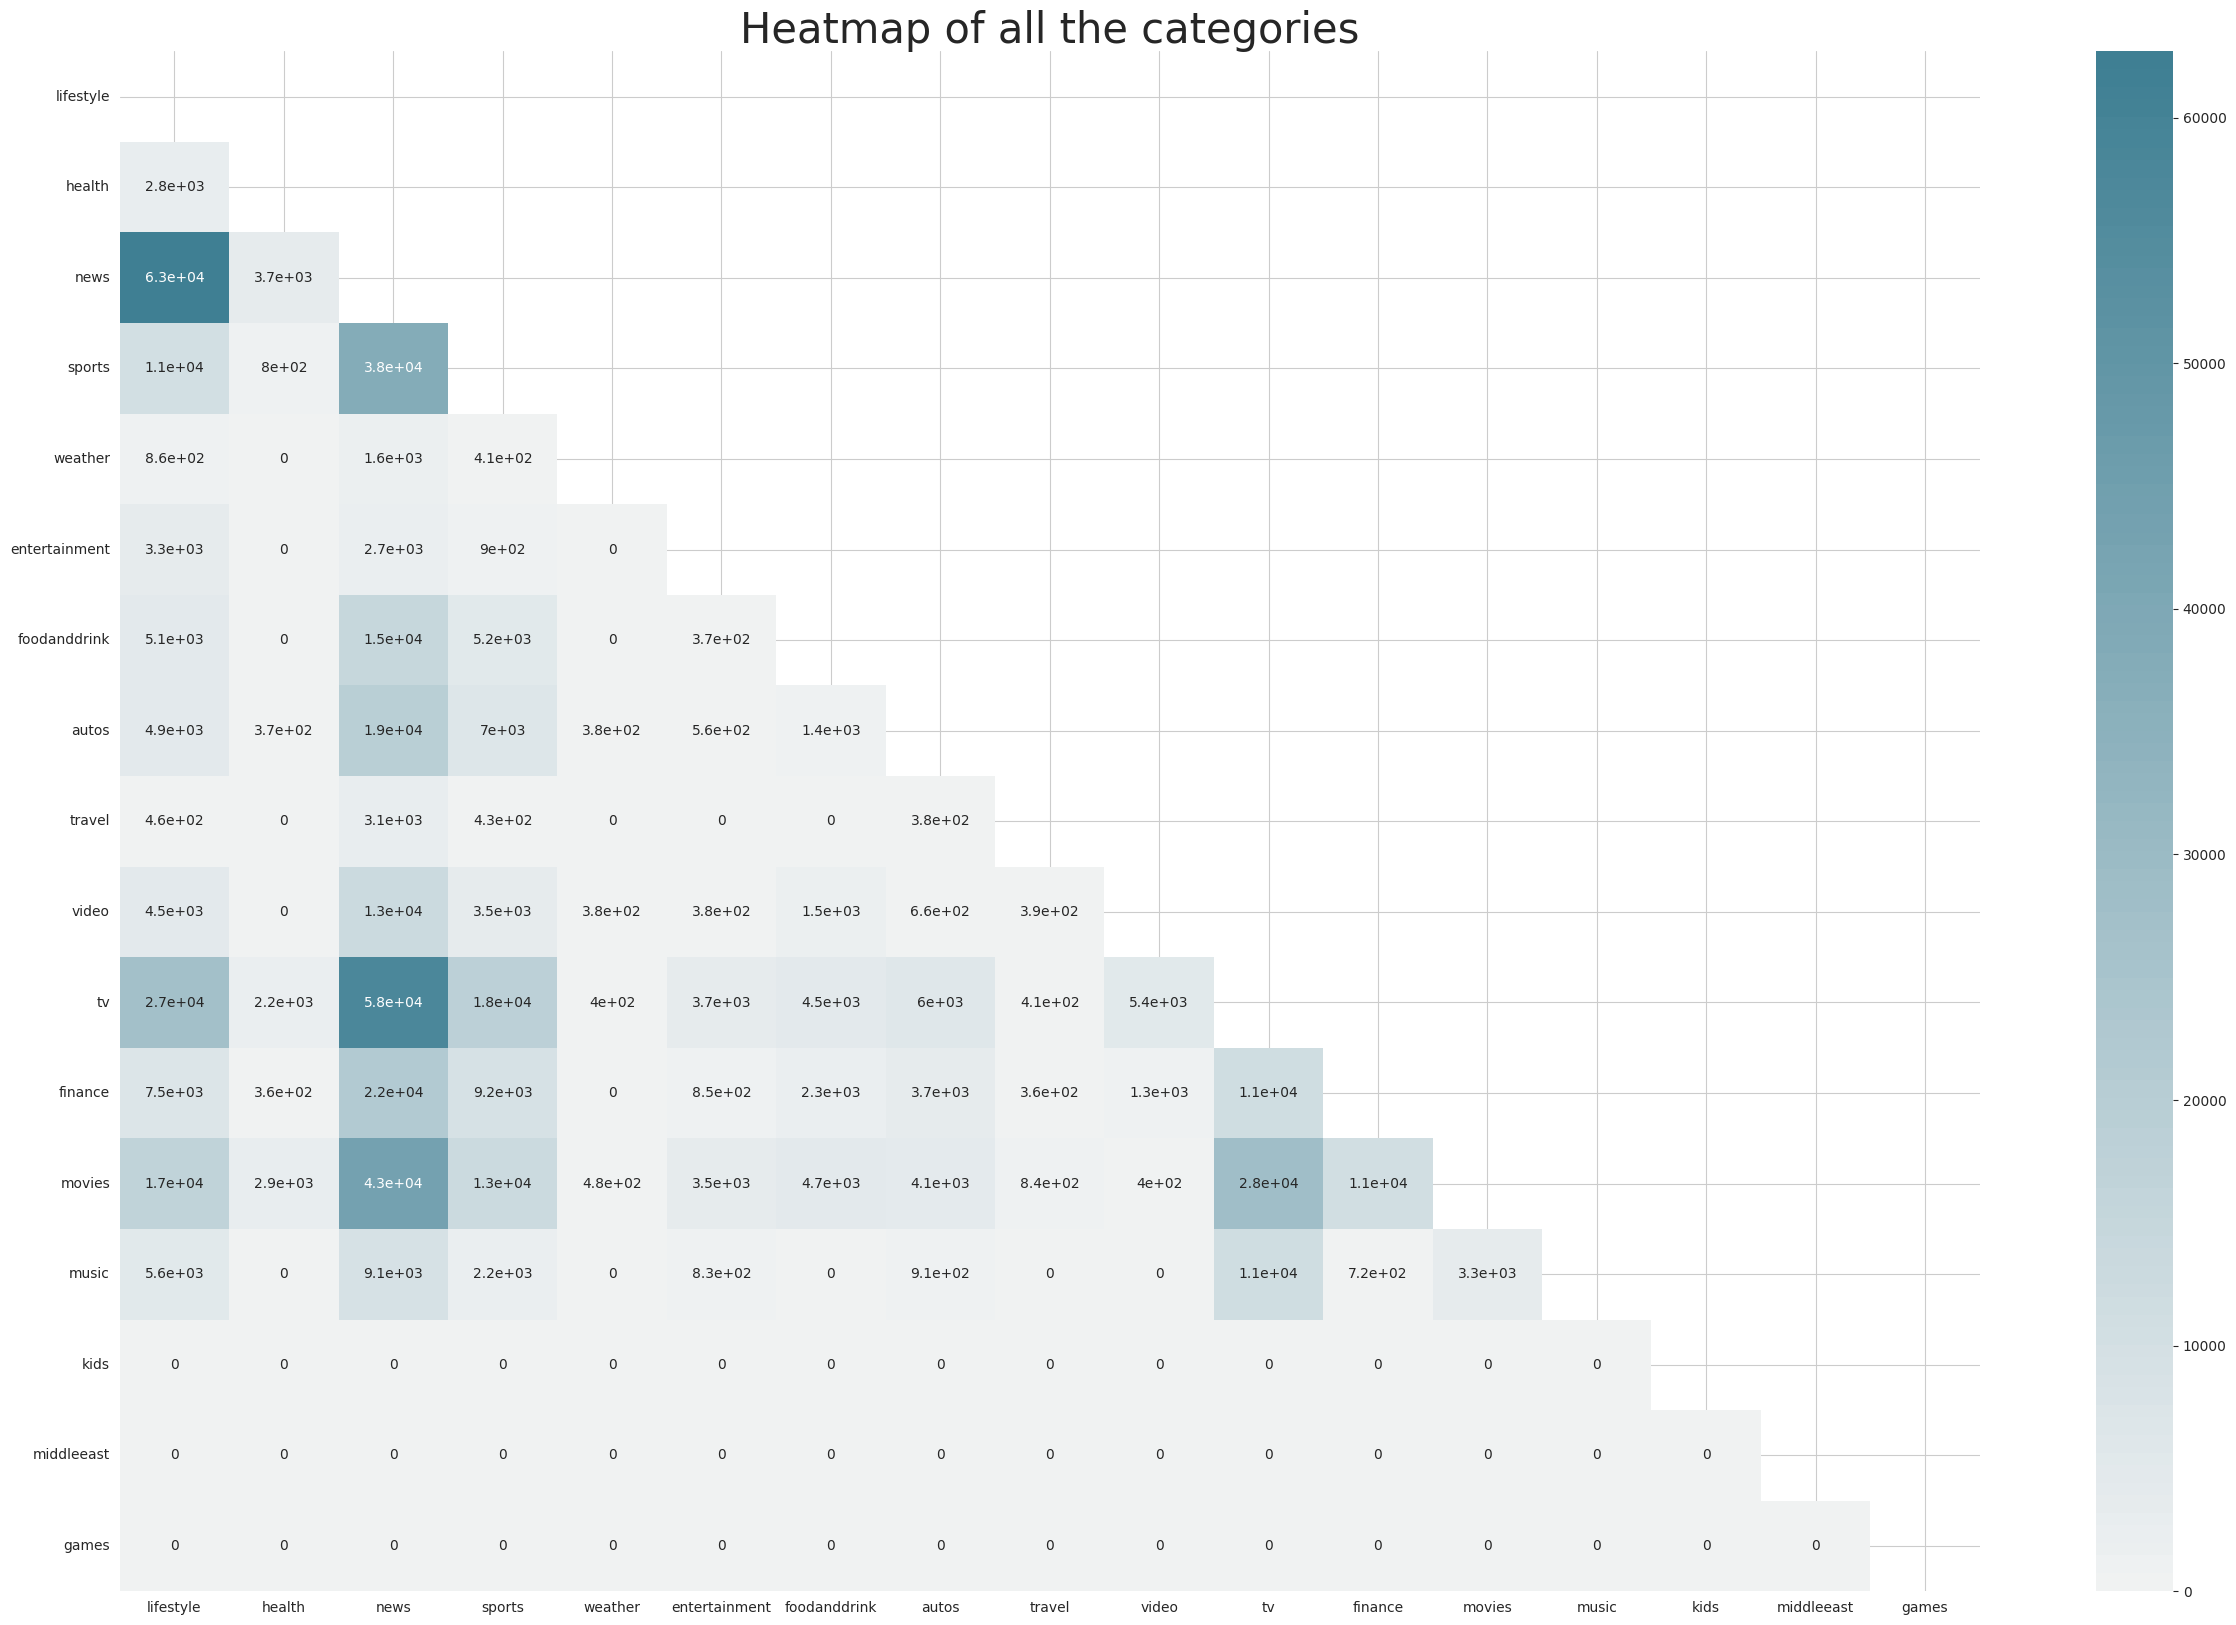

In [36]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


def corr_heatmap(itemsets, categories, title: str=None):
    corr = np.zeros((len(categories), len(categories)), dtype=int)
    for i, cat1 in enumerate(categories):
        for j, cat2 in enumerate(categories):
            key1 = (cat1, cat2)
            key2 = (cat2, cat1)
            if key1 in itemsets:
                corr[i][j] = itemsets[key1]
                corr[j][i] = itemsets[key1]
            elif key2 in itemsets_transformed:
                corr[i][j] = itemsets[key2]
                corr[j][i] = itemsets[key2]
    # 设置绘图风格
    sns.set_style("whitegrid")
    # 设置画板尺寸
    plt.subplots(figsize=(30, 20))

    # 画热力图
    # 为上三角矩阵生成掩码
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    sns.heatmap(
        corr,
        cmap=sns.diverging_palette(20, 220, n=200),
        mask=mask,  # 数据显示在mask为False的单元格中
        annot=True,  # 注入数据
        center=0,  # 绘制有色数据时将色彩映射居中的值,
        xticklabels=categories,
        yticklabels=categories
    )
    if title is not None:
        plt.title(title, fontsize=30)


corr_heatmap(itemsets_transformed_all, categories, "Heatmap of all the categories")

## DBLP数据集

### 0. 数据预处理

In [ ]:
! wget -c https://dblp.dagstuhl.de/xml/dblp.xml.gz -O /data/mza/site-packages/dblp-parser/dblp.xml
! wget -c https://dblp.dagstuhl.de/xml/dblp.dtd -O /data/mza/site-packages/dblp-parser/dblp.dtd

In [1]:
from dblp_parser import DBLP
dblp = DBLP()

dblp_path = "/data/mza/site-packages/dblp-parser/dblp.xml"
save_path = "/data/mza/site-packages/dblp-parser/dblp.jsonl"
dblp.parse_all(dblp_path, save_path, features_to_extract=['author', 'booktitle', 'crossref', 'title', 'year'])

2024-04-23 02:28:00 DBLP Successfully loaded "/data/mza/site-packages/dblp-parser/dblp.xml".
2024-04-23 02:28:00 DBLP Parsing all. Started.
2024-04-23 02:30:41 DBLP Parsing all. Finished.


### 1. 数据加载

In [2]:
import json

dblp_data = []
with open(save_path, 'r+', encoding='utf-8') as f:
    for line in f.readlines():
        dblp_data.append(json.loads(line))
print(f"dblp_data ({len(dblp_data)}): {dblp_data[0]}")

dblp_data (10691463): {'type': 'incollection', 'title': 'Curvedness.', 'author': [], 'year': '2014', 'crossref': '', 'booktitle': 'Computer Vision, A Reference Guide'}


In [12]:
dblp_author_dict = dict()
for item in dblp_data:
    for author in item['author']:
        if author not in dblp_author_dict:
            dblp_author_dict[author] = 1
        else:
            dblp_author_dict[author] += 1
            
sorted_dblp_author_dict = {author: freq for author, freq in sorted(dblp_author_dict.items(), key = lambda kv:(kv[1], kv[0]), reverse=True)}
print(f"sorted_dblp_author_dict ({len(sorted_dblp_author_dict)})")
for i, (author, freq) in enumerate(sorted_dblp_author_dict.items()):
    if i > 50:
        break
    print(f"{author}: {freq}")

sorted_dblp_author_dict (3586124)
H. Vincent Poor: 2889
Yang Liu: 2299
Philip S. Yu: 2113
Wei Wang: 2076
Yu Zhang: 2060
Wei Zhang: 2057
Mohamed-Slim Alouini: 2043
Dacheng Tao: 1910
Zhu Han 0001: 1821
Lajos Hanzo: 1800
Lei Wang: 1796
Xin Wang: 1666
Wei Li: 1658
Witold Pedrycz: 1642
Jing Wang: 1626
Hai Jin 0001: 1610
Wei Liu: 1581
Victor C. M. Leung: 1561
Lei Zhang: 1559
Luc Van Gool: 1553
Yi Zhang: 1549
Luca Benini: 1533
Xin Li: 1507
Jing Zhang: 1482
Mohsen Guizani: 1470
Jing Li: 1452
Yan Wang: 1445
Yang Li: 1440
Licheng Jiao: 1440
Nassir Navab: 1437
Yan Zhang: 1429
Wen Gao 0001: 1427
Dusit Niyato: 1410
Hao Wang: 1398
Yong Wang: 1355
Yan Li: 1346
Li Zhang: 1294
Xi Chen: 1293
Yang Yang: 1288
Leonard Barolli: 1287
Xuelong Li 0001: 1276
Jun Zhang: 1259
Jiawei Han 0001: 1253
Yu Wang: 1239
Robert Schober: 1235
Tao Wang: 1234
Li Li: 1233
Dinggang Shen: 1227
Hao Zhang: 1226
Hui Li: 1220
Jun Wang: 1215


筛选活跃作者

In [17]:
selected_authors = set(list(sorted_dblp_author_dict.keys())[:10000])

filtered_dblp_data = []
for item in dblp_data:
    authors = set(item['author'])
    if len(authors.intersection(selected_authors)) != 0:
        filtered_dblp_data.append(item)
        
print(f"filtered_dblp_data: {len(filtered_dblp_data)}")

filtered_dblp_data: 2236302


In [18]:
filtered_dblp_authors = [item['author'] for item in filtered_dblp_data]

### 2. 频繁模式挖掘（项集）

构造论文合作关系项集

In [40]:
from efficient_apriori import apriori

itemsets, rules = apriori(filtered_dblp_authors, min_support=0.0001, min_confidence=0.0001)

print(f"itemsets ({len(itemsets[2])}): {itemsets[2]}")
print(f"rules ({len(rules)}): {rules}")

itemsets (90): {('Abbas Khosravi', 'Saeid Nahavandi'): 226, ('Amr El Abbadi', 'Divyakant Agrawal'): 329, ('Anastasios Tefas', 'Ioannis Pitas'): 231, ('Andrea Passarella', 'Marco Conti'): 241, ('Bin Guo 0001', 'Zhiwen Yu 0001'): 354, ('Bing Xue 0001', 'Mengjie Zhang 0001'): 375, ('Björn E. Ottersten', 'Symeon Chatzinotas'): 518, ('Bo Ai 0001', 'Zhangdui Zhong'): 289, ('Branka Vucetic', 'Yonghui Li 0001'): 480, ('Chao-Kai Wen', 'Shi Jin 0002'): 243, ('Chun Chen 0001', 'Jiajun Bu'): 291, ("Ciriaco Andrea D'Angelo", 'Giovanni Abramo'): 240, ('Clinton Fookes', 'Sridha Sridharan'): 331, ('Craig Macdonald', 'Iadh Ounis'): 254, ('Daniel Lokshtanov', 'Saket Saurabh 0001'): 297, ('Daniel Thalmann', 'Nadia Magnenat-Thalmann'): 226, ('David T. Blaauw', 'Dennis Sylvester'): 395, ('Depeng Jin', 'Yong Li 0008'): 360, ('Derrick Wing Kwan Ng', 'Robert Schober'): 225, ('Didier Dubois', 'Henri Prade'): 412, ('Dong In Kim', 'Dusit Niyato'): 230, ('Dusit Niyato', 'Ping Wang 0001'): 306, ('Dusit Niyato', 'Z

绘制部分高频作者论文合作关系

分析：
* 由于算力限制，本节论文合作关系的项集构造仅选用了前10000名高发表量作者，对于最终合作关系的展示仅涉及数十位作者，因此结果展示中每位作者最多仅有一位高频合作者
* 论文合作关系相对固定。由对更大规模的项集数据分析可知，即使初始数据规模扩大到一定程度后，每位作者的论文合作者数量依然保持在稳定水平，说明绝大多数作者的论文合作关系相对固定

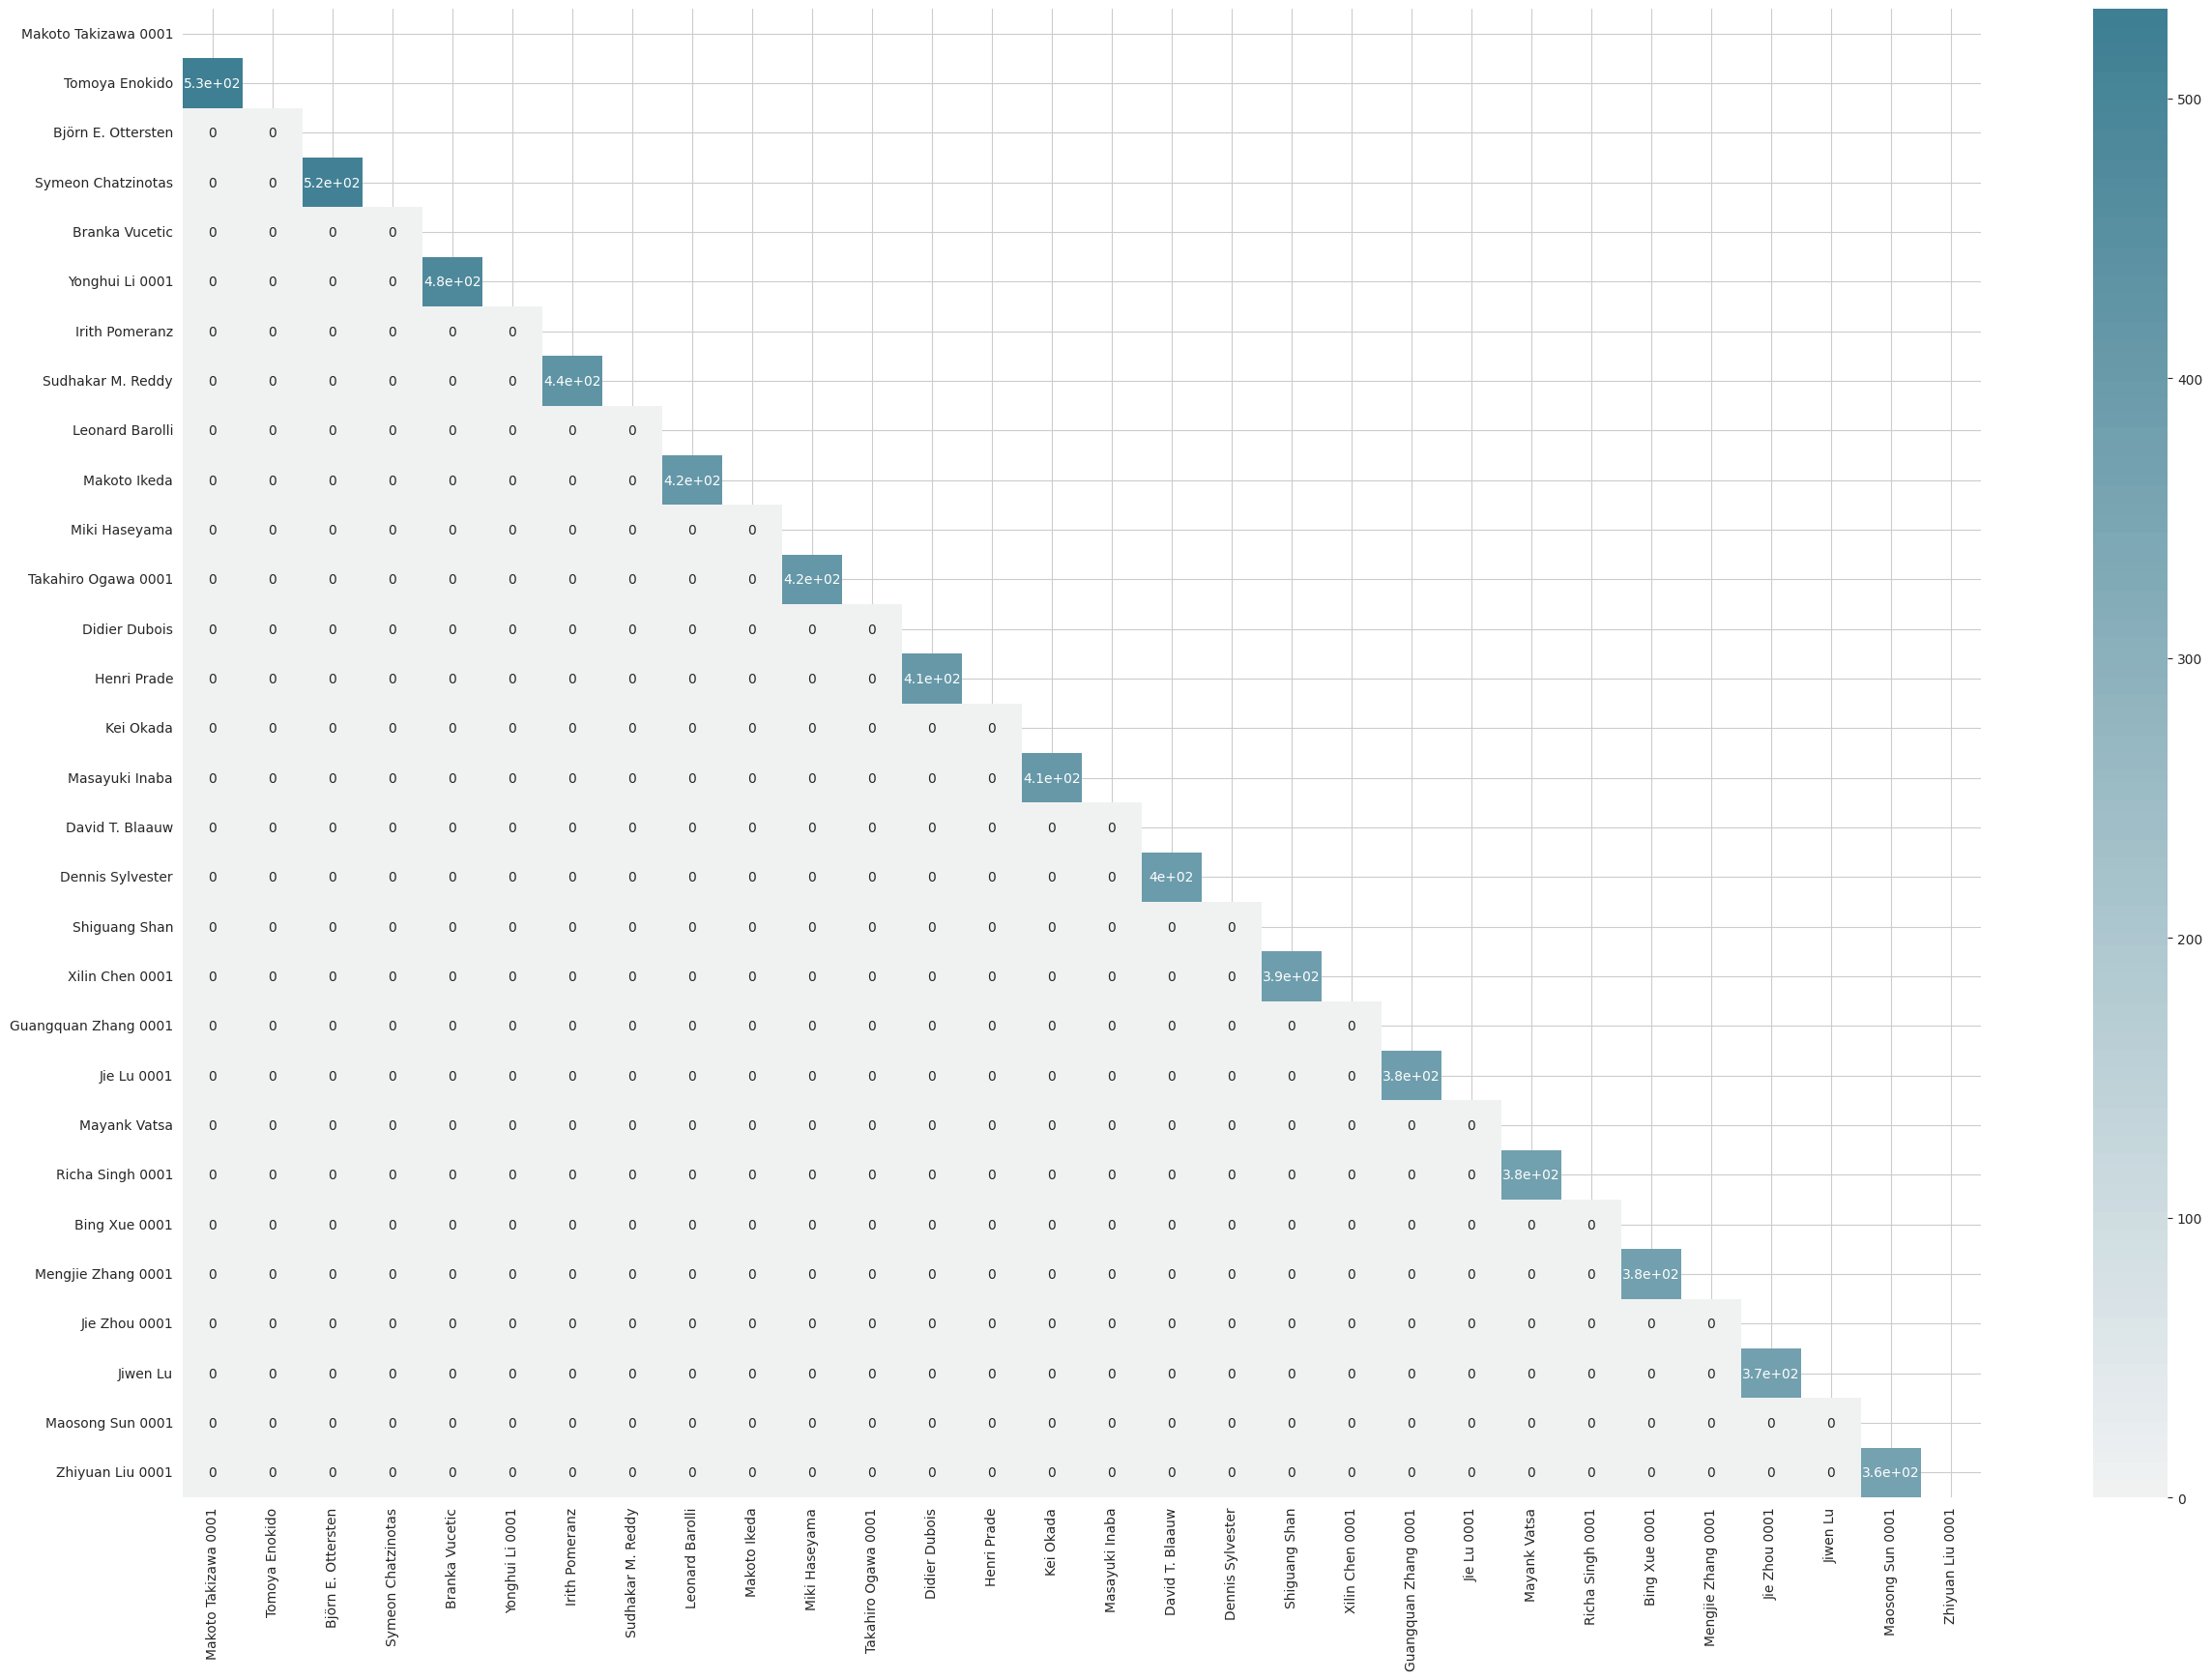

In [53]:
selected_itemsets = {authors: freq for authors, freq in sorted(itemsets[2].items(), key = lambda kv:(kv[1], kv[0]), reverse=True)[:15]}

final_authors = []
for author1, author2 in selected_itemsets.keys():
    if author1 not in final_authors:
        final_authors.append(author1)
    if author2 not in final_authors:
        final_authors.append(author2)
        
corr_heatmap(selected_itemsets, final_authors)